# Edited: Sama
# Spleen 3D CT Regression with MONAI



## Setup environment

In [7]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib


from monai.utils import first, set_determinism
from monai.transforms import (EnsureChannelFirstd, Compose, CropForegroundd, LoadImaged, Orientationd, RandCropByPosNegLabeld, ScaleIntensityRanged, Spacingd)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn

2023-12-14 17:56:53.447718: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 17:56:53.447768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 17:56:53.449007: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 17:56:54.525841: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Set MSD Spleen dataset path

In [3]:
from google.colab import drive
drive.mount('/content/drive')
root_dir = '/content/drive/My Drive/MONAI_data'
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"
os.makedirs(root_dir, exist_ok=True)
compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
# Create data dictionaries
data_dicts = [{"image": img, "target": img} for img in train_images]
# making  smaller input to save time for practing stage:
train_files, val_files = data_dicts[-9:], data_dicts[-9:]

set_determinism(seed=0)

Mounted at /content/drive


## Define CacheDataset and DataLoader

In [24]:

train_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        ScaleIntensityRanged(keys=["image"],a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "target"], source_key="image"),
        Orientationd(keys=["image", "target"], axcodes="RAS"),
        Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(keys=["image", "target"],label_key="target", spatial_size=(96, 96, 96), pos=1, neg=1, num_samples=4,image_key="image",image_threshold=0),
        ])
val_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        ScaleIntensityRanged(keys=["image", "target"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "target"], source_key="image"),
        Orientationd(keys=["image", "target"], axcodes="RAS"),
        Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),])

train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=2)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)


Loading dataset: 100%|██████████| 9/9 [00:30<00:00,  3.44s/it]


image shape: torch.Size([228, 158, 113]), target shape: torch.Size([228, 158, 113])


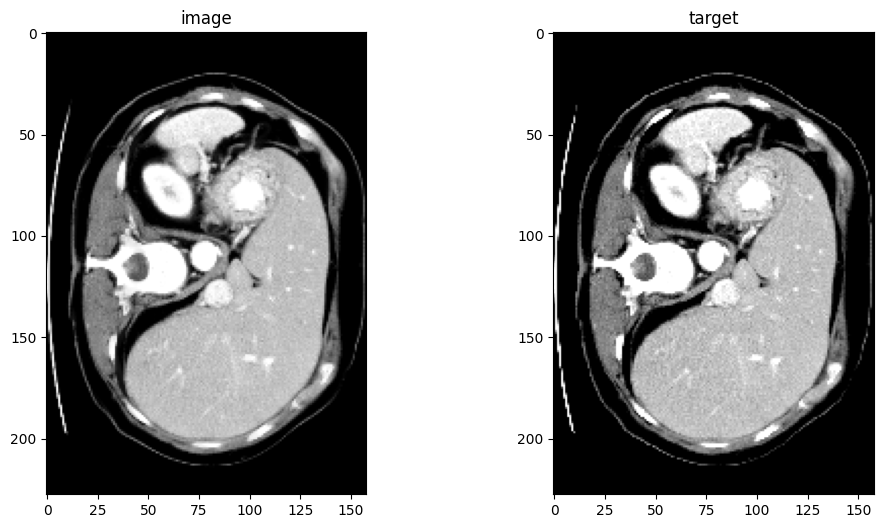

In [25]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, target = (check_data["image"][0][0], check_data["target"][0][0])
print(f"image shape: {image.shape}, target shape: {target.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("target")
plt.imshow(target[:, :, 80], cmap= "gray")
plt.show()

## Create Model, Loss, Optimizer

In [26]:

device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    act=(nn.ReLU, {"inplace": True}),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-6)

## Execute a typical PyTorch training process

In [18]:

max_epochs = 5
val_interval = 2
best_metric = float('inf')
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["target"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["target"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_loss += loss_function(val_outputs, val_labels).item()

            val_loss /= len(val_loader)
            metric_values.append(val_loss)
            if val_loss < best_metric:
                best_metric = val_loss
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current val loss: {val_loss:.4f}"
                f"\nbest val loss: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )


----------
epoch 1/5
1/2, train_loss: 196416.2500
2/2, train_loss: 200802.4062
3/2, train_loss: 173970.1562
epoch 1 average loss: 190396.2708
----------
epoch 2/5
1/2, train_loss: 234334.0781
2/2, train_loss: 174367.4062
3/2, train_loss: 101030.4922
epoch 2 average loss: 169910.6589
saved new best metric model
current epoch: 2 current val loss: 0.0970
best val loss: 0.0970 at epoch: 2
----------
epoch 3/5
1/2, train_loss: 164604.7812
2/2, train_loss: 259720.9062
3/2, train_loss: 319070.3750
epoch 3 average loss: 247798.6875
----------
epoch 4/5
1/2, train_loss: 138874.0156
2/2, train_loss: 246581.8594
3/2, train_loss: 229153.8281
epoch 4 average loss: 204869.9010
current epoch: 4 current val loss: 0.1019
best val loss: 0.0970 at epoch: 2
----------
epoch 5/5
1/2, train_loss: 280314.0312
2/2, train_loss: 139463.3594
3/2, train_loss: 160741.2031
epoch 5 average loss: 193506.1979


In [19]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.0970 at epoch: 2


## Plot the loss and metric

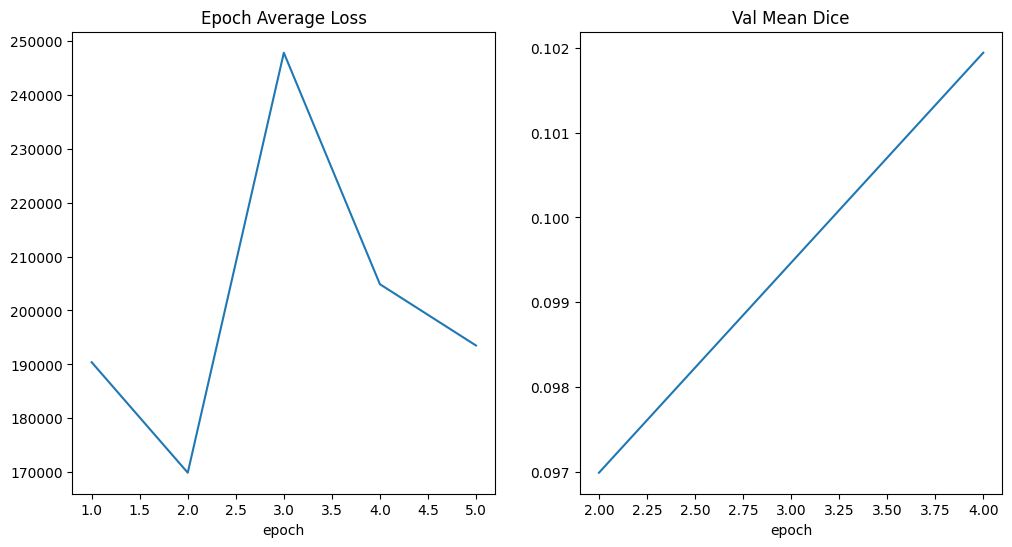

In [20]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

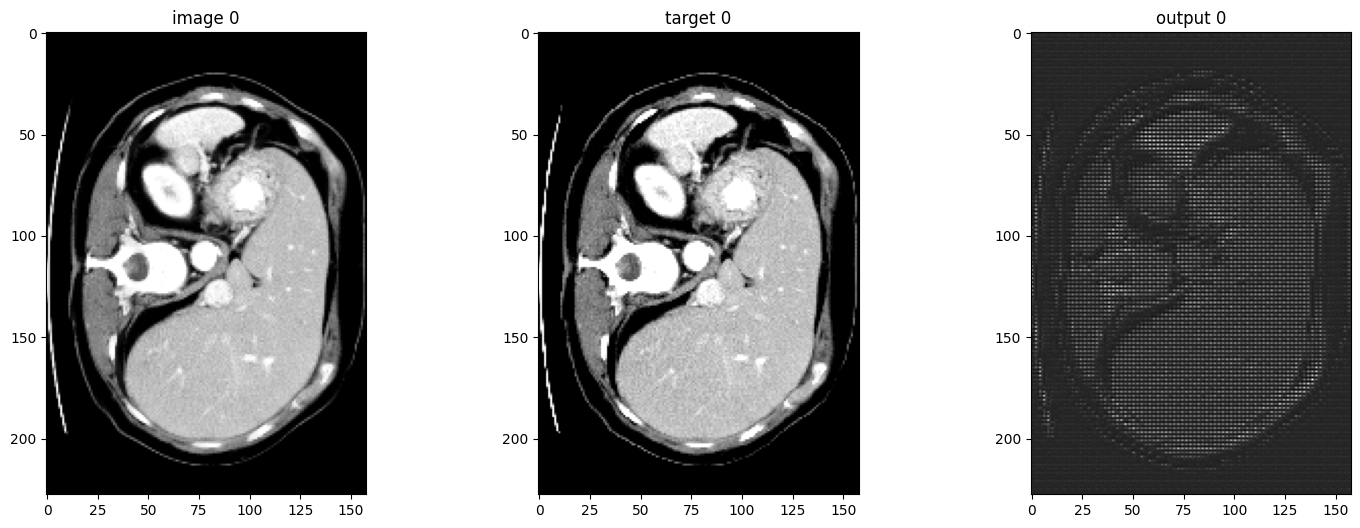

In [21]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)

        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")

        plt.subplot(1, 3, 2)
        plt.title(f"target {i}")
        plt.imshow(val_data["target"][0, 0, :, :, 80], cmap="gray")

        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        output_slice = val_outputs.detach().cpu()[0, 0, :, :, 80]
        # Assuming the output values are normalized, adjust if not
        plt.imshow(output_slice, cmap="gray")
        plt.show()
        if i == 0:
            break


---------------------

In [ ]:
# val_org_transforms = Compose(
#     [
#         LoadImaged(keys=["image", "target"]),
#         EnsureChannelFirstd(keys=["image", "target"]),
#         Orientationd(keys=["image"], axcodes="RAS"),
#         Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
#         ScaleIntensityRanged(
#             keys=["image"],
#             a_min=-57,
#             a_max=164,
#             b_min=0.0,
#             b_max=1.0,
#             clip=True,
#         ),
#         CropForegroundd(keys=["image"], source_key="image"),
#     ]
# )

# val_org_ds = Dataset(data=val_files, transform=val_org_transforms)
# val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

# post_transforms = Compose(
#     [
#         Invertd(
#             keys="pred",
#             transform=val_org_transforms,
#             orig_keys="image",
#             meta_keys="pred_meta_dict",
#             orig_meta_keys="image_meta_dict",
#             meta_key_postfix="meta_dict",
#             nearest_interp=False,
#             to_tensor=True,
#             device="cpu",
#         ),
#         AsDiscreted(keys="pred", argmax=True, to_onehot=2),
#         AsDiscreted(keys="target", to_onehot=2),
#     ]
# )

In [ ]:
# model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
# model.eval()

# with torch.no_grad():
#     for val_data in val_org_loader:
#         val_inputs = val_data["image"].to(device)
#         roi_size = (160, 160, 160)
#         sw_batch_size = 4
#         val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
#         val_data = [post_transforms(i) for i in decollate_batch(val_data)]
#         val_outputs, val_labels = from_engine(["pred", "target"])(val_data)
#         # compute metric for current iteration
#         dice_metric(y_pred=val_outputs, y=val_labels)

#     # aggregate the final mean dice result
#     metric_org = dice_metric.aggregate().item()
#     # reset the status for next validation round
#     dice_metric.reset()

# print("Metric on original image spacing: ", metric_org)

In [ ]:
# test_images = sorted(glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

# test_data = [{"image": image} for image in test_images]


# test_org_transforms = Compose(
#     [
#         LoadImaged(keys="image"),
#         EnsureChannelFirstd(keys="image"),
#         Orientationd(keys=["image"], axcodes="RAS"),
#         Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
#         ScaleIntensityRanged(
#             keys=["image"],
#             a_min=-57,
#             a_max=164,
#             b_min=0.0,
#             b_max=1.0,
#             clip=True,
#         ),
#         CropForegroundd(keys=["image"], source_key="image"),
#     ]
# )

# test_org_ds = Dataset(data=test_data, transform=test_org_transforms)

# test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

# post_transforms = Compose(
#     [
#         Invertd(
#             keys="pred",
#             transform=test_org_transforms,
#             orig_keys="image",
#             meta_keys="pred_meta_dict",
#             orig_meta_keys="image_meta_dict",
#             meta_key_postfix="meta_dict",
#             nearest_interp=False,
#             to_tensor=True,
#         ),
#         AsDiscreted(keys="pred", argmax=True, to_onehot=2),
#         SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
#     ]
# )

In [ ]:
# model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
# model.eval()

# with torch.no_grad():
#     for test_data in test_org_loader:
#         test_inputs = test_data["image"].to(device)
#         roi_size = (160, 160, 160)
#         sw_batch_size = 4
#         test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

#         test_data = [post_transforms(i) for i in decollate_batch(test_data)]

# #         # uncomment the following lines to visualize the predicted results
# #         test_output = from_engine(["pred"])(test_data)

# #         original_image = loader(test_output[0].meta["filename_or_obj"])

# #         plt.figure("check", (18, 6))
# #         plt.subplot(1, 2, 1)
# #         plt.imshow(original_image[:, :, 20], cmap="gray")
# #         plt.subplot(1, 2, 2)
# #         plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
# #         plt.show()